# Projet MAP473D : Simulation Moléculaire #
### Barthélémy Bulteau - Smail El Hafdi ###

Imports des libraires nécessaires au projet

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Représentation graphique de la fonction potentiel $V(x) = \frac{x^4}{4} + \frac{x^3}{3} - \frac{x^2}{2}$ et de ses minimas situés en $x_1 \approx -1.618$ et $x_2 \approx 0.618$.

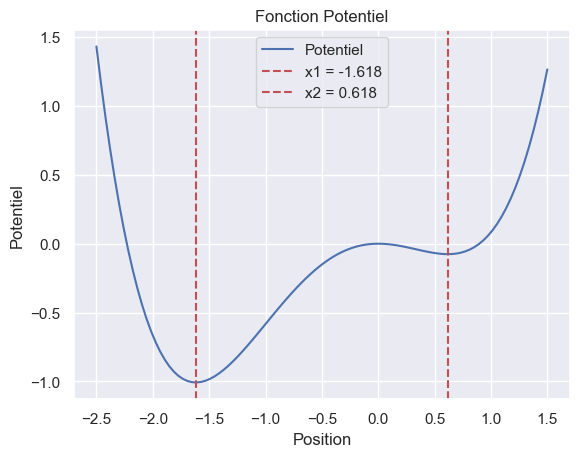

In [2]:
# Fonction potentiel
def V(x):
    return (3*x**4 + 4*x**3 - 6*x**2)/12

# Dérivée
def Vprime(x):
    return x*(x**2 + x - 1)

# Abscisses des minimas
x1 = (-1-np.sqrt(5))/2
x2 = (-1+np.sqrt(5))/2

# représentation graphique
x = np.linspace(-2.5, 1.5, 100)
plt.plot(x, V(x), label='Potentiel')
plt.title("Fonction Potentiel")
# plot vertical line for x1 and x2
plt.axvline(x1, color='r', linestyle='--', label=f'x1 = {round(x1, 3)}')
plt.axvline(x2, color='r', linestyle='--', label=f'x2 = {round(x2, 3)}')
plt.xlabel("Position")
plt.ylabel("Potentiel")
plt.legend()
plt.show()

Calcul de la probabilité de l'évènement $R$ par méthode de Monte-Carlo naïve et présentation de la variation de celle-ci en fonction des pramètres $\epsilon$ et $h$.

Proba de R : P(R) = 0.1416


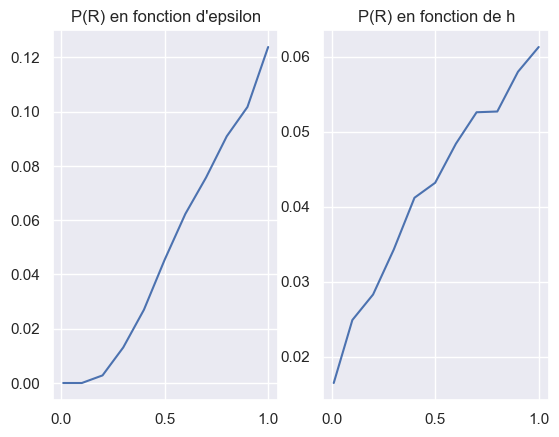

In [3]:
# Calcul de la proba de R={t2 < t1}, P(R) = E(1{t2-t1}) par méthode de Monte-Carlo naïve
def MC_naif(X0, epsilon, h, N):
    E = 0
    global x1
    global x2
    sigma = np.sqrt(2*epsilon*h)

    for _ in range(N):
        Xn = X0
        while Xn >= x1 and Xn <= x2:
            Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
        if Xn > x2:
            E += 1

    return E/N

# Exemple d'une estimation
print("Proba de R : P(R) = {}".format(MC_naif(x1+0.1, 1, 1, 10000)))

# Variations en fonction d'epsilon
epsilons = [0.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
plt.subplot(1, 2, 1)
plt.plot(epsilons, [MC_naif(x1+0.1, e, 0.5, 10000) for e in epsilons])
plt.title("P(R) en fonction d'epsilon")

# Variations en fonction de h
hs = [0.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
plt.subplot(1, 2, 2)
plt.plot(hs, [MC_naif(x1+0.1, 0.5, h, 10000) for h in hs])
plt.title("P(R) en fonction de h")

plt.show()

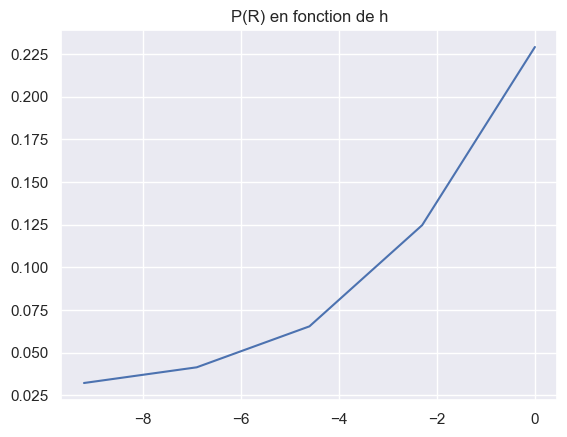

In [12]:
hs = [0.0001, 0.001, 0.01, 0.1, 1]
plt.plot(np.log(hs), [MC_naif(x1+0.1, 2, h, 10000) for h in hs])
plt.title("P(R) en fonction de h")
plt.show()

In [18]:
MC_naif(x1+0.1, 2, 0.1, 1000000)

0.126198

Utilisation de l'algorithme AMS pour le calcul de la probabilité de l'évènement $R$.

In [13]:
def simulation_trajectoire(X0, h, sigma):
    # simulation d'une trajectoire
    Xn = X0
    traj = [X0]
    while Xn >= x1 and Xn <= x2:
        Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
        traj.append(Xn)
    return np.array(traj)

def K(trajectoires):
    # retourne le plus petit maximum des trajectoires
    return np.amin([np.amax(traj) for traj in trajectoires])

def I(trajectoires, K_value):
    # retourne les indices des trajectoires dont le maximum est K_value
    return [i for i, traj in enumerate(trajectoires) if np.amax(traj) == K_value]

def estimateur_AMS(X0, M, h, epsilon, debug=False):
    # variables
    global x2
    trajectoires = []
    I_q = []
    K_q = 0
    sigma = np.sqrt(2*epsilon*h)
    p_estim = 1

    # simulation initiale
    trajectoires = [simulation_trajectoire(X0, h, sigma) for _ in range(M)]
    K_q = K(trajectoires)
    I_q = I(trajectoires, K_q)
    p_estim *= 1 - len(I_q)/M

    q = 0
    while K_q < x2:
        if debug:
            print("Iteration n°{} \t K_q/x2 = {}".format(q, K_q/x2))

        # (i) Branchement
        indices = list(set(range(M)) - set(I_q))
        for m in I_q:
            p = np.random.choice(indices)
            idx = np.where(trajectoires[p] > K_q)[0][0]
            trajectoires[m] = np.concatenate((trajectoires[p][:idx], simulation_trajectoire(trajectoires[p][idx], h, sigma)))

        # (ii) Calcul du niveau
        K_q = K(trajectoires)
        I_q = I(trajectoires, K_q)
        p_estim *= 1 - len(I_q)/M

        q += 1

    return p_estim

# Exemple d'une estimation
print("Proba de R : P(R) = {}".format(estimateur_AMS(x1+0.1, 1000, 0.1, 0.1)))

Proba de R : P(R) = 1.1869436168119213e-05


In [19]:
estimateur_AMS(x1+0.1, 1000, 0.1, 2)

0.13639944984234156

Comparaison des résultats obtenus à l'aide des deux algorithmes :

(/!\ Attention : temps d'execution long... ~2min)

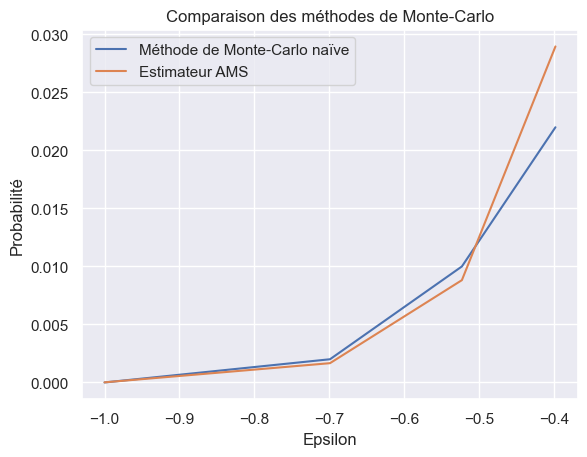

In [15]:
epsilons = [0.1*i for i in range(1, 5)]
hs = [0.1*i for i in range(1, 5)]

naif = [MC_naif(x1+0.1, epsilons[i], hs[i], 1000) for i in range(len(epsilons))]
AMS = [estimateur_AMS(x1+0.1, 1000, hs[i], epsilons[i]) for i in range(len(epsilons))]

plt.plot(np.log10(epsilons), naif, label='Méthode de Monte-Carlo naïve')
plt.plot(np.log10(epsilons), AMS, label='Estimateur AMS')
plt.title("Comparaison des méthodes de Monte-Carlo")
plt.xlabel("Epsilon")
plt.ylabel("Probabilité")
plt.legend()
# sauvegarde de l'image
plt.savefig("comparaison.png")
plt.show()